In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# data loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))])
trainset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

print('Data configuration')
print('Train :', trainset.train_data.size())
print('Test :', testset.test_data.size())

# setting
input_n = 28*28
hidden_n = 100
k = 10

n_test = 4
n_epoch = 100
n_valid = 100
batch_size = 100
lr = 0.001

cuda = torch.cuda.is_available()

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=n_test, shuffle=True, num_workers=2 )

Data configuration
Train : torch.Size([60000, 28, 28])
Test : torch.Size([10000, 28, 28])


/home/hanseul/.local/lib/python3.5/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/hanseul/.local/lib/python3.5/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [2]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('fc') != -1:
        torch.nn.init.kaiming_normal(m.weight.data)
        torch.nn.init.kaiming_normal(m.bias.data)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # encoding
        self.fc1 = nn.Linear(input_n, hidden_n)
        # mu & std
        self.fc21 = nn.Linear(hidden_n, k)
        self.fc22 = nn.Linear(hidden_n, k)
        # decoding
        self.fc3 = nn.Linear(k, hidden_n)
        self.fc4 = nn.Linear(hidden_n, input_n)

    def forward(self, x):
        mu, log_var = self.encoding(x)
        z = self.reparametrizing(mu, log_var)
        recon_x = self.decoding(z)

        return recon_x, mu, log_var
    def encoding(self, x):
        x = F.relu(self.fc1(x))
        mu = F.relu(self.fc21(x))
        log_var = F.relu(self.fc22(x))
        return mu, log_var

    def reparametrizing(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_(mean=0, std=1).cuda()
        z = eps.mul(std).add_(mu)
        return z

    def decoding(self, z):
        recon_x = F.relu(self.fc3(z))
        recon_x = torch.sigmoid(self.fc4(recon_x))
        return recon_x

In [4]:
net = Net()
if cuda:
    net.cuda()
net.apply(weight_init)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.BCELoss(size_average=False)

/home/hanseul/.local/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [5]:
# training
for e in range(n_epoch):
    valid_loss = 0.0
    for b, data in enumerate(trainloader):
        image, label = data
        image = image.view(image.size(0), -1)
        image, label = Variable(image), Variable(label)
        if cuda:
            image, label = image.cuda(), label.cuda()

        optimizer.zero_grad()

        # recon loss
        recon_x, mu, log_var = net(image)

        # KL loss
        # = 0.5 * sum(mu^2 + sigma^2 + log(sigma^2) - 1)
        KLD = torch.sum(mu ** 2 + log_var.exp() - (log_var) - 1).mul_(0.5)

        loss = criterion(recon_x, image) + KLD
        loss.backward()
        optimizer.step()

        valid_loss += loss
        if (b % n_valid) == (n_valid - 1):
            print('{0:2d} epoch {1:4d} batch : loss : {2:.5f}'.format(e, b + 1, valid_loss / n_valid))
            valid_loss = 0.0

 0 epoch  100 batch : loss : 29235.98438
 0 epoch  200 batch : loss : 21435.80273
 0 epoch  300 batch : loss : 20031.08008
 0 epoch  400 batch : loss : 19530.05664
 0 epoch  500 batch : loss : 19077.30273
 0 epoch  600 batch : loss : 18812.79492
 1 epoch  100 batch : loss : 18549.74805
 1 epoch  200 batch : loss : 18316.49414
 1 epoch  300 batch : loss : 18180.91016
 1 epoch  400 batch : loss : 17963.85938
 1 epoch  500 batch : loss : 17798.96289
 1 epoch  600 batch : loss : 17749.62305
 2 epoch  100 batch : loss : 17854.85156
 2 epoch  200 batch : loss : 17672.07031
 2 epoch  300 batch : loss : 17681.30273
 2 epoch  400 batch : loss : 17605.52930
 2 epoch  500 batch : loss : 17465.05664
 2 epoch  600 batch : loss : 17514.88477
 3 epoch  100 batch : loss : 17524.81641
 3 epoch  200 batch : loss : 17550.63672
 3 epoch  300 batch : loss : 17554.84180
 3 epoch  400 batch : loss : 17485.53320
 3 epoch  500 batch : loss : 17482.11914
 3 epoch  600 batch : loss : 17360.63477
 4 epoch  100 ba

33 epoch  300 batch : loss : 16437.08008
33 epoch  400 batch : loss : 16406.90430
33 epoch  500 batch : loss : 16442.45508
33 epoch  600 batch : loss : 16451.50000
34 epoch  100 batch : loss : 16507.02930
34 epoch  200 batch : loss : 16408.40234
34 epoch  300 batch : loss : 16422.60547
34 epoch  400 batch : loss : 16390.82031
34 epoch  500 batch : loss : 16405.81055
34 epoch  600 batch : loss : 16367.20996
35 epoch  100 batch : loss : 16441.55273
35 epoch  200 batch : loss : 16395.48047
35 epoch  300 batch : loss : 16429.13867
35 epoch  400 batch : loss : 16471.72656
35 epoch  500 batch : loss : 16383.65332
35 epoch  600 batch : loss : 16426.16992
36 epoch  100 batch : loss : 16438.87500
36 epoch  200 batch : loss : 16419.95703
36 epoch  300 batch : loss : 16383.69824
36 epoch  400 batch : loss : 16464.14453
36 epoch  500 batch : loss : 16349.45801
36 epoch  600 batch : loss : 16478.13672
37 epoch  100 batch : loss : 16334.51855
37 epoch  200 batch : loss : 16515.25195
37 epoch  300 ba

66 epoch  500 batch : loss : 16367.39844
66 epoch  600 batch : loss : 16361.85254
67 epoch  100 batch : loss : 16371.25879
67 epoch  200 batch : loss : 16368.52344
67 epoch  300 batch : loss : 16263.20605
67 epoch  400 batch : loss : 16333.75977
67 epoch  500 batch : loss : 16279.44043
67 epoch  600 batch : loss : 16331.39941
68 epoch  100 batch : loss : 16336.60254
68 epoch  200 batch : loss : 16356.02051
68 epoch  300 batch : loss : 16353.10059
68 epoch  400 batch : loss : 16365.45312
68 epoch  500 batch : loss : 16290.52832
68 epoch  600 batch : loss : 16336.33594
69 epoch  100 batch : loss : 16324.89258
69 epoch  200 batch : loss : 16382.19727
69 epoch  300 batch : loss : 16382.17480
69 epoch  400 batch : loss : 16323.63965
69 epoch  500 batch : loss : 16283.42871
69 epoch  600 batch : loss : 16273.19824
70 epoch  100 batch : loss : 16403.07617
70 epoch  200 batch : loss : 16273.61816
70 epoch  300 batch : loss : 16317.25684
70 epoch  400 batch : loss : 16224.31348
70 epoch  500 ba

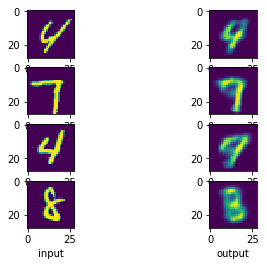

In [10]:
# plot
fig = plt.figure()

test_input, label = next(iter(testloader))
test_input = test_input.view(test_input.size(0), -1)
test_input = Variable(test_input)

if cuda:
    test_input = test_input.cuda()
test_output, m, l_v = net(test_input)
if cuda:
    test_input = test_input.cpu().detach()
    test_output = test_output.cpu().detach()
    
row = n_test
col = 2

for r in range(row):
    test_input = test_input.view((test_input.size(0), 28, 28))
    test_output = test_output.view((test_output.size(0), 28, 28))
    ax = fig.add_subplot(row, col, 2*r+1)
    ax.imshow(test_input[r].numpy())
    ax.set_xlabel('input')

    bx=fig.add_subplot(row, col, 2*r+2)
    bx.imshow(test_output[r].cpu().detach().numpy())
    bx.set_xlabel('output')

plt.show()
